# Feature Selection

For the regression model we would like to reduce the number of required features, which would make it easier to use as forecasting model.  
Some of the recoded features are rather hard to measure, e.g. *lambda_30*, *lamda_40*, *s*, *Delta_T*, *nu*, *Q_p*, while other are easier to measure, e.g. *wind*, *Hs*, *p*, *swell*, *kh*, *T_air*, *L_deep*, *T_p*, *Delta_p_1h*.

## Setup

Importing all required packages and define seed and number of cores to use.

In [1]:
import os
import pandas as pd
import numpy as np
import sys
import pickle

import matplotlib.pyplot as plt

sys.path.append('./')
import utils

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr


In [2]:
seed = 42
n_jobs = 4
print(f"Using {n_jobs} cores from {os.cpu_count()} available cores.") # how many CPU cores are available on the current machine

Using 4 cores from 8 available cores.


In [3]:
undersample = True
undersample_method = "random"
case = 3
model_type = "reg"

num_cv = 10

## Load the Data

Training dataset target distribution:
Counter({0: 14264, 1: 14264, 2: 14264})
Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})
Loaded the following model: RandomForestRegressor(criterion='poisson', max_depth=50, max_features='sqrt',
                      max_samples=0.95, n_estimators=1000, oob_score=True,
                      random_state=42)
Train set MSE: 0.001
Train set R^2: 0.99
Train set Spearman R: 0.994


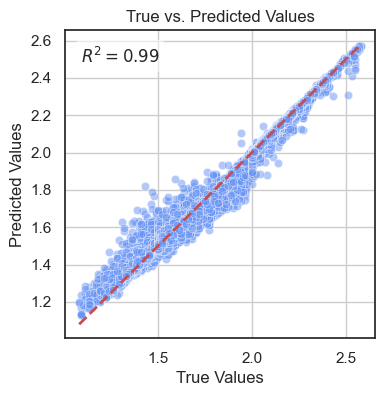

Test set MSE: 0.01
Test set R^2: 0.674
Test set Spearman R: 0.806


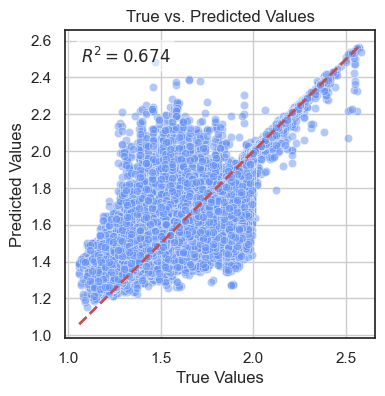

In [4]:
# Load and unpack the data
model_full, X_train, y_train, y_train_cat, X_test, y_test, y_test_cat = utils.load_data_and_model(model_type, case, undersample_method, undersample)

Check the correlation matrix to see if we have redundant features.

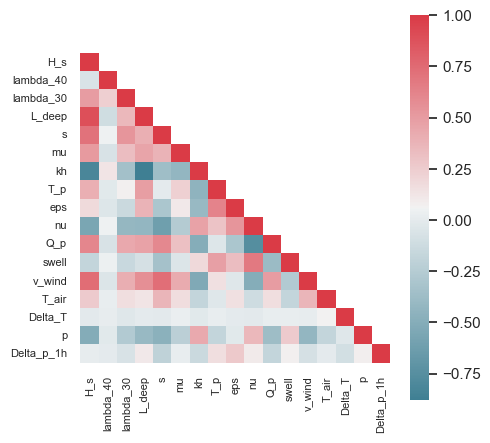

In [5]:
utils.plot_correlation_matrix(X_train, figsize=(5, 5), annot=False, labelsize=8)

## Feature Selection

### Feature Selection with Recursive Feature Elimination

A Recursive Feature Elimination (RFE) example with automatic tuning of the number of features selected with cross-validation.  
For further information see:
- https://scikit-learn.org/1.5/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
- https://medium.com/@loyfordmwenda/recursive-feature-rfe-elimination-with-scikit-learn-d0d29e96273d

In [6]:
# Define the regression model and use the hyperparameters from gridsearch for full regression model
params = model_full.get_params()

# initialize a new Random Forest Regressor with the same parameter settings
model = RandomForestRegressor(**params)

In [7]:
# Define the RFE parameters
min_features_to_select = 1  # Minimum number of features to consider

In [8]:
# Run RFE
skf = StratifiedKFold(n_splits=num_cv).split(X_train, y_train_cat)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=skf,
    scoring="r2",
    min_features_to_select=min_features_to_select,
    n_jobs=n_jobs,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {X_train.columns[rfecv.support_]}")

/opt/anaconda3/envs/rogue_wave/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Optimal number of features: 17
Selected features: Index(['H_s', 'lambda_40', 'lambda_30', 'L_deep', 's', 'mu', 'kh', 'T_p',
       'eps', 'nu', 'Q_p', 'swell', 'v_wind', 'T_air', 'Delta_T', 'p',
       'Delta_p_1h'],
      dtype='object')


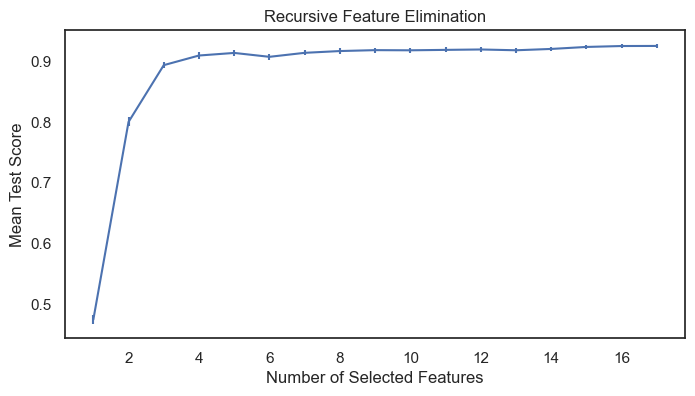

In [9]:
# Plot results
cv_results = pd.DataFrame(rfecv.cv_results_)

plt.figure(figsize=(8, 4))
plt.xlabel("Number of Selected Features")
plt.ylabel("Mean Test Score")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination")
plt.show()

In [10]:
pd.DataFrame({"feature removed": ["-"] + list(X_train.columns[rfecv.support_])[::-1], "mean test score":  list(cv_results["mean_test_score"])[::-1] + [0]})

,feature removed,mean test score
0,-,0.926177
1,Delta_p_1h,0.926053
2,p,0.924531
3,Delta_T,0.921236
4,T_air,0.919032
5,v_wind,0.920345
6,swell,0.919681
7,Q_p,0.918977
8,nu,0.919246
9,eps,0.917750


The recursive feature elimination returns all features (17) giving the best score, however, from the table above, we can see that the top 7 features lead to a similar mean test score. Hence, we will retrain the RF model with only the top 4 features: *H_s*, *lambda_40*, *lambda_30*, *L_deep*.

Building model for case 3 with random undersampled data and top features: ['H_s', 'lambda_40', 'lambda_30', 'L_deep', 's', 'mu', 'kh'].

Train set MSE: 0.002
Train set R^2: 0.978
Train set Spearman R: 0.988


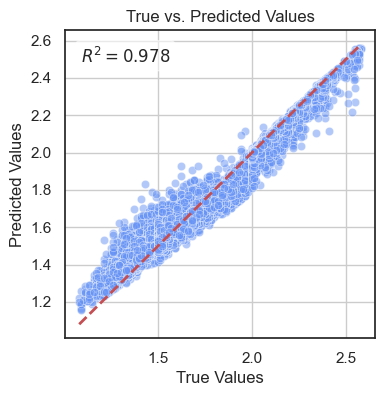


Test set MSE: 0.018
Test set R^2: 0.402
Test set Spearman R: 0.586


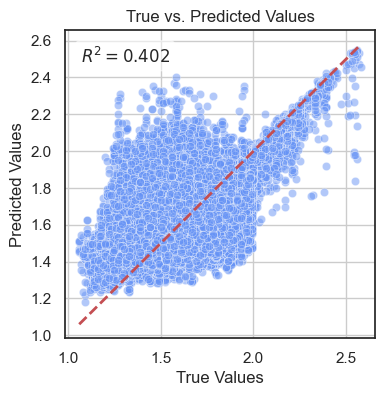

In [11]:
top_features = ["H_s","lambda_40","lambda_30","L_deep", "s", "mu", "kh"]

print(f'Building model for case {case}' + f'{f" with {undersample_method} undersampled data" if undersample else ""} and top features: {top_features}.')
model.fit(X_train[top_features], y_train)

# Train performance
y_pred = model.predict(X_train[top_features])
y_true = y_train

print(f"\nTrain set MSE: {round(mean_squared_error(y_true, y_pred), 3)}")
print(f"Train set R^2: {round(r2_score(y_true, y_pred), 3)}")
print(f"Train set Spearman R: {round(spearmanr(y_true, y_pred).correlation, 3)}")

utils.plot_predictions(y_true=y_true, y_pred=y_pred, textstr = f'$R^2={round(r2_score(y_true, y_pred), 3)}$')

# Test performance
y_pred = model.predict(X_test[top_features])
y_true = y_test

print(f"\nTest set MSE: {round(mean_squared_error(y_true, y_pred), 3)}")
print(f"Test set R^2: {round(r2_score(y_true, y_pred), 3)}")
print(f"Test set Spearman R: {round(spearmanr(y_true, y_pred).correlation, 3)}")

utils.plot_predictions(y_true=y_true, y_pred=y_pred, textstr = f'$R^2={round(r2_score(y_true, y_pred), 3)}$')

### Sequential Feature Selection

SFS is a greedy procedure where, at each iteration, we choose the best new feature to add to our selected features based a cross-validation score. That is, we start with 0 features and choose the best single feature with the highest score. The procedure is repeated until we reach the desired number of selected features.  
For further information see:

- https://scikit-learn.org/1.5/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py


In [12]:
# Define the regression model and use the hyperparameters from gridsearch for full regression model
params = model_full.get_params()

# initialize a new Random Forest Regressor with the same parameter settings
model = RandomForestRegressor(**params)

In [13]:
# Define the SFS parameters
tol = 0.05 # we use the r^2 score for a RandomForest Regressor
n_features_to_select = "auto"
direction = "forward"
scoring = "r2"

In [14]:
# Run SFS
skf = StratifiedKFold(n_splits=num_cv).split(X_train, y_train_cat)
sfs = SequentialFeatureSelector(model, n_features_to_select=n_features_to_select, tol=tol, direction=direction, scoring=scoring, cv=skf)
sfs.fit(X_train, y_train)

print(f"Optimal number of features: {sfs.n_features_to_select_}")
print(f"Selected features: {X_train.columns[sfs.support_]}")

Optimal number of features: 2
Selected features: Index(['v_wind', 'p'], dtype='object')


The sequential feature selector returns 2 features leading to the best score. The selected features are *v_wind* and *p*. Hence, we will retrain the RF model with only those features.

Building model for case 3 with random undersampled data and top features: ['v_wind', 'p'].

Train set MSE: 0.008
Train set R^2: 0.921
Train set Spearman R: 0.941


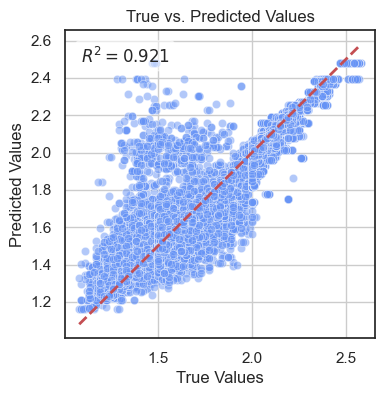


Test set MSE: 0.015
Test set R^2: 0.488
Test set Spearman R: 0.727


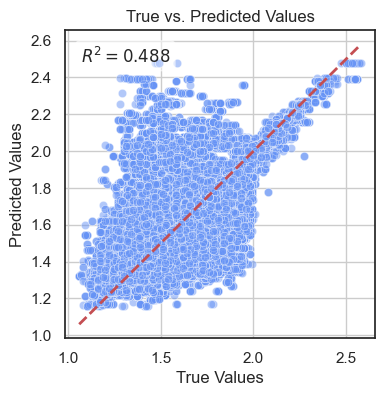

In [15]:
top_features = ["v_wind", "p"]

print(f'Building model for case {case}' + f'{f" with {undersample_method} undersampled data" if undersample else ""} and top features: {top_features}.')
model.fit(X_train[top_features], y_train)

# Train performance
y_pred = model.predict(X_train[top_features])
y_true = y_train

print(f"\nTrain set MSE: {round(mean_squared_error(y_true, y_pred), 3)}")
print(f"Train set R^2: {round(r2_score(y_true, y_pred), 3)}")
print(f"Train set Spearman R: {round(spearmanr(y_true, y_pred).correlation, 3)}")

utils.plot_predictions(y_true=y_true, y_pred=y_pred, textstr = f'$R^2={round(r2_score(y_true, y_pred), 3)}$')

# Test performance
y_pred = model.predict(X_test[top_features])
y_true = y_test

print(f"\nTest set MSE: {round(mean_squared_error(y_true, y_pred), 3)}")
print(f"Test set R^2: {round(r2_score(y_true, y_pred), 3)}")
print(f"Test set Spearman R: {round(spearmanr(y_true, y_pred).correlation, 3)}")

utils.plot_predictions(y_true=y_true, y_pred=y_pred, textstr = f'$R^2={round(r2_score(y_true, y_pred), 3)}$')